In [1]:
import SimpleITK as sitk
import itk
import itkwidgets 
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import ipywidgets as widgets
import cv2
from tqdm.notebook import tqdm

In [2]:
mr_image = sitk.ReadImage(Path("data/anonymise_patient2.mhd"))
npa = sitk.GetArrayViewFromImage(mr_image)

# Display the image slice from the middle of the stack, z axis
z = int(mr_image.GetDepth()/2)
npa_zslice = sitk.GetArrayViewFromImage(mr_image)[z,:,:]

#itkwidgets.view(mr_image)

In [3]:
selected_image = mr_image
print("Before modification:")
print("origin: " + str(selected_image.GetOrigin()))
print("size: " + str(selected_image.GetSize()))
print("spacing: " + str(selected_image.GetSpacing()))
print("direction: " + str(selected_image.GetDirection()))
print("pixel type: " + str(selected_image.GetPixelIDTypeAsString()))
print(
    "number of pixel components: " + str(selected_image.GetNumberOfComponentsPerPixel())
)


Before modification:
origin: (-231.0, -231.0, 322.0)
size: (512, 512, 1530)
spacing: (0.904, 0.904, 0.8)
direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
pixel type: 16-bit signed integer
number of pixel components: 1


In [4]:
image_array = sitk.GetArrayFromImage(mr_image)
histogram, bin_edges = np.histogram(image_array.flatten(),bins=255)
plt.plot(bin_edges[0:-1], histogram, color='blue')
plt.title("Histogramme de l'image médicale")
plt.xlabel("Valeur des pixels")
plt.ylabel("Fréquence")
plt.show()


In [ ]:

thresholdFilter = sitk.IntensityWindowingImageFilter()
thresholdFilter.SetWindowMinimum(0)
thresholdFilter.SetWindowMaximum(1000)
thresholdFilter.SetOutputMinimum(0)
thresholdFilter.SetOutputMaximum(255)
resultTreshold = thresholdFilter.Execute(mr_image)

#itkwidgets.view(resultTreshold)


In [ ]:
# #Convert sitk to itk image
# itk_image = itk.GetImageFromArray(sitk.GetArrayFromImage(resultTreshold), is_vector = resultTreshold.GetNumberOfComponentsPerPixel()>1)
# itk_image.SetOrigin(resultTreshold.GetOrigin())
# itk_image.SetSpacing(resultTreshold.GetSpacing())   
# itk_image.SetDirection(itk.GetMatrixFromArray(np.reshape(np.array(resultTreshold.GetDirection()), [3]*2)))


In [ ]:
# cleaned_thresh_img = sitk.BinaryOpeningByReconstruction(resultTreshold, [10, 10, 10])
# cleaned_thresh_img = sitk.BinaryClosingByReconstruction(
#     cleaned_thresh_img, [10, 10, 10]
# )
# MultiImageDisplay(
#     image_list=[cleaned_thresh_img],
#     title_list=["Cleaned Binary Segmentation"],
#     figure_size=(8, 4),
# );


In [ ]:
# itkwidgets.view(sitk.Cast(sitk.ConnectedComponent(resultTreshold),sitk.sitkUInt8))

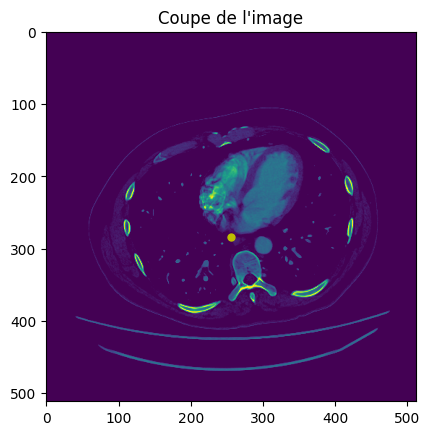

In [ ]:
# thresholdFilter = sitk.IntensityWindowingImageFilter()
# thresholdFilter.SetWindowMinimum(0)
# thresholdFilter.SetWindowMaximum(150)
# thresholdFilter.SetOutputMinimum(0)
# thresholdFilter.SetOutputMaximum(255)
# resultTargetBonesAndVessels = thresholdFilter.Execute(resultTreshold)
image_array = sitk.GetArrayFromImage(resultTreshold)
plt.title("Coupe de l'image")
plt.plot([255],[284], marker='o', ls='none', ms=5,color="y")
plt.imshow(image_array[-1,:,:])
np.save(Path("temp/preprocessed_image.npy"), image_array)